# Recommender Systems 2020/21

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [4]:
import sys  
import scipy.sparse as sps
import numpy as np
import pandas as pd


In [5]:
sys.path.insert(0, '../datasets/')
from load_tables import load_ICM_csr, load_URM_csr
ICM_all, ICM_tuples = load_ICM_csr(tuples=True)
URM_all = load_URM_csr()


# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [6]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [7]:
print(features_per_item.shape)
print(items_per_feature.shape)

(25975,)
(20000,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

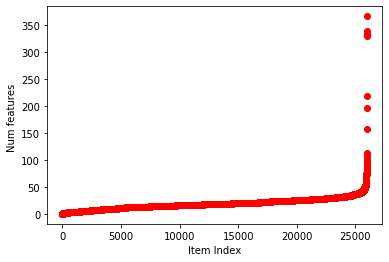

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

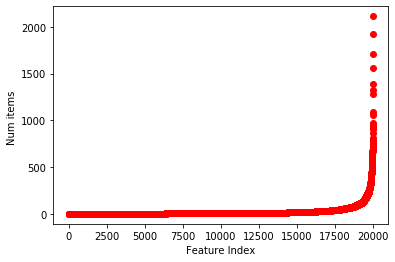

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [16]:
sys.path.insert(0, '../Lab/')

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


In [17]:
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [18]:
item_id = 50
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [19]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([0.05343304, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [20]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([2.03970191, 1.7198036 , 2.03170329, ..., 1.88591954, 1.58197029,
       2.41299477])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [21]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([14.58356463, 13.86469771, 14.56559035, ..., 14.237989  ,
       13.55496238, 15.42241839])

In [22]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [23]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   50, 17616,  9887, ..., 11577, 11597, 25974])

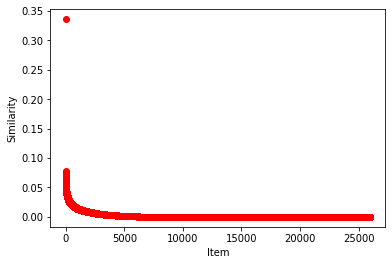

In [24]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [25]:
k = 100

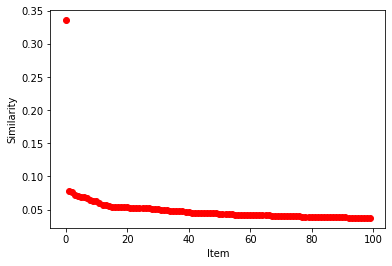

In [26]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [27]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [28]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 25975)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [29]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity one item at a time runs at 85.05 items/sec


In [30]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)

    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity in blocks of 100 items at a time runs at 3873.74 items/sec


### In this case the vectorized implementation runs >50 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [31]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity with nested loops runs at 19.80 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

## Test our CBF recommender:

In [32]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 25975 ( 100 % ), 1012.31 column/sec, elapsed time 0.43 min


In [33]:
userList_unique = list(set(userList_icm))
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

NameError: name 'userList_icm' is not defined

#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [36]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 19.63 usr/sec


### Let's add a common mistake.... a CSC URM

In [35]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 25975 ( 100 % ), 1061.62 column/sec, elapsed time 0.41 min


In [34]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 65135 is out of bounds for axis 0 with size 65134


Traceback (most recent call last):
  File "<ipython-input-34-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-15-88972fee293e>", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-15-88972fee293e>", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 65135 is out of bounds for axis 0 with size 65134


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [37]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 871.26 column/sec, elapsed time 0.50 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 5.31 sec. Users per second: 1056
ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25300 ( 97 % ), 841.90 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 841.93 column/sec, elapsed time 0.51 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 4.07 sec. Users per second: 1379
ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 893.99 column/sec,

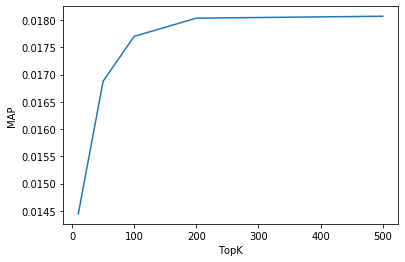

In [38]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [39]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22500 ( 87 % ), 748.42 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 750.32 column/sec, elapsed time 0.58 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 6.69 sec. Users per second: 838
ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 988.18 column/sec, elapsed time 0.44 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 10.52 sec. Users per second: 533
ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 1030.59 column/sec,

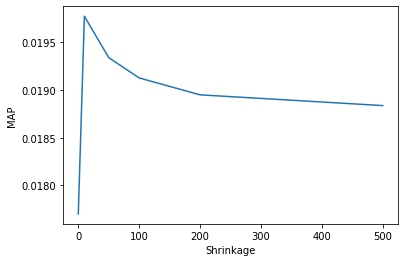

In [40]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [41]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(25975, 20000)
(20000,)


/Users/08volt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [42]:
IDF

array([8.5554519 , 9.06627753, 9.47174264, ..., 8.37313035, 5.8474017 ,
       7.33167647])

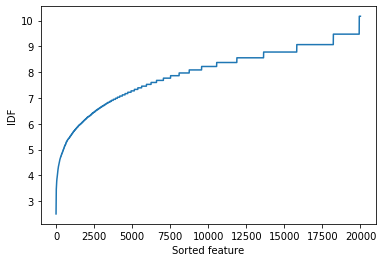

In [43]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [47]:
from sklearn import preprocessing
tagList_icm = range(20000)
ICM_label_encoder = preprocessing.LabelEncoder()
ICM_label_encoder.fit(tagList_icm)

tagList_icm = ICM_label_encoder.transform(tagList_icm)



In [48]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]
ICM_label_encoder.inverse_transform(highest_ranked_features)

array([ 7294, 11584,  7172,  9983,  6416, 14205, 13805, 17382, 19511,
       13814, 14540,  7161,  2278,  2557,  7029,   826, 11926, 11664,
         841,   164])

#### Lowest ranked features

In [49]:
lowest_ranked_features = sorted_features[-20:]
ICM_label_encoder.inverse_transform(lowest_ranked_features)

array([ 1359,  4978, 19692,  1962, 17393, 13103,  7000, 15509, 17975,
        1980, 11764,  8428, 14770, 13151,  6182, 11888,  1868, 11253,
        3398, 11565])

In [50]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(20000,)
(25975, 20000)
(20000,)


In [51]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 1118.20 column/sec, elapsed time 0.39 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 3.77 sec. Users per second: 1486


{'ROC_AUC': 0.05843595741910646,
 'PRECISION': 0.012143366619115603,
 'PRECISION_RECALL_MIN_DEN': 0.039545476416909996,
 'RECALL': 0.03822411067042284,
 'MAP': 0.01654224292744517,
 'MRR': 0.03944025541743082,
 'NDCG': 0.02690267595748142,
 'F1': 0.018431313797683625,
 'HIT_RATE': 0.12143366619115549,
 'ARHR': 0.04352759946108728,
 'NOVELTY': 0.0049388816597842645,
 'AVERAGE_POPULARITY': 0.0174481062039652,
 'DIVERSITY_MEAN_INTER_LIST': 0.9969766941007865,
 'DIVERSITY_HERFINDAHL': 0.9996798916516246,
 'COVERAGE_ITEM': 0.5975360923965352,
 'COVERAGE_ITEM_CORRECT': 0.02410009624639076,
 'COVERAGE_USER': 0.7056750975210772,
 'COVERAGE_USER_CORRECT': 0.06996350824210394,
 'DIVERSITY_GINI': 0.2791383009313546,
 'SHANNON_ENTROPY': 12.996732137618942}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# BM25

In [52]:
from Base.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [53]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 221 (2.78 %) cold users.
ItemKNNCBFRecommender: URM Detected 3966 (15.27 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25975 ( 100 % ), 1267.83 column/sec, elapsed time 0.34 min
EvaluatorHoldout: Processed 5608 ( 100.00% ) in 3.58 sec. Users per second: 1566


{'ROC_AUC': 0.06574152146593312,
 'PRECISION': 0.013338088445078462,
 'PRECISION_RECALL_MIN_DEN': 0.0448174942825441,
 'RECALL': 0.043408158403358155,
 'MAP': 0.018990239452493642,
 'MRR': 0.04572641407965937,
 'NDCG': 0.030673041778647166,
 'F1': 0.020405996455355645,
 'HIT_RATE': 0.13338088445078458,
 'ARHR': 0.05047260999026329,
 'NOVELTY': 0.004948502557320007,
 'AVERAGE_POPULARITY': 0.017403345075548082,
 'DIVERSITY_MEAN_INTER_LIST': 0.9971386388575316,
 'DIVERSITY_HERFINDAHL': 0.9996960832395538,
 'COVERAGE_ITEM': 0.639153031761309,
 'COVERAGE_ITEM_CORRECT': 0.026217516843118384,
 'COVERAGE_USER': 0.7056750975210772,
 'COVERAGE_USER_CORRECT': 0.07789102806090349,
 'DIVERSITY_GINI': 0.3133257993112923,
 'SHANNON_ENTROPY': 13.146569450085416}

#### Another small gain over TF-IDF

# Unnormalized similarity matrix

In [50]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_dict, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
EvaluatorHoldout: Processed 19000 ( 27.22% ) in 30.41 sec. Users per second: 625
EvaluatorHoldout: Processed 38000 ( 54.45% ) in 1.01 min. Users per second: 627
EvaluatorHoldout: Processed 57000 ( 81.67% ) in 1.52 min. Users per second: 627
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.86 min. Users per second: 625


{'ROC_AUC': 0.3254914743348736,
 'PRECISION': 0.11686702104798023,
 'PRECISION_RECALL_MIN_DEN': 0.12451347624576094,
 'RECALL': 0.051125396743676214,
 'MAP': 0.06731911481276623,
 'MRR': 0.2935413259482405,
 'NDCG': 0.08068561452935788,
 'F1': 0.07113264867393673,
 'HIT_RATE': 1.168670210479561,
 'ARHR': 0.42350010541375344,
 'NOVELTY': 0.0014455765492946955,
 'AVERAGE_POPULARITY': 0.4957891156325233,
 'DIVERSITY_MEAN_INTER_LIST': 0.781303051769327,
 'DIVERSITY_HERFINDAHL': 0.9781291857193198,
 'COVERAGE_ITEM': 0.008628366137501151,
 'COVERAGE_ITEM_CORRECT': 0.003976417846286118,
 'COVERAGE_USER': 0.9751984126984127,
 'COVERAGE_USER_CORRECT': 0.5271769505924435,
 'DIVERSITY_GINI': 0.0007898098592797655,
 'SHANNON_ENTROPY': 6.06052068984684}